In [63]:
# def H_star(absorptivity=0.3, power=400.0, rho=2500.0, Cp=915.0, T_solid=853.0, T_0=300.0, hf=40000.0, Diffusivity=0.000097, scan_speed=0.5, beam_diameter=0.0001):

#     H = (4 * absorptivity * power)/(np.pi*rho*(Cp*(T_solid - T_0) + hf) * np.sqrt(Diffusivity * scan_speed * beam_diameter**3))

# loss = (-(H_star(power, scan_speed)-115)**2 - 1000*((scan_speed - 3)**2))

In [64]:
#  State space 

episode: 0/1000, reward: -0.8010447175764155
episode: 1/1000, reward: -0.1580863050522463
episode: 2/1000, reward: -0.179988022146146
episode: 3/1000, reward: -0.09409066448917654
episode: 4/1000, reward: -0.11016201494737962
episode: 5/1000, reward: -5.261758811970694
episode: 6/1000, reward: -0.13052452558969452
episode: 7/1000, reward: -0.12058476572369516
episode: 8/1000, reward: -0.33417684031495054
episode: 9/1000, reward: -0.27125658192010066
episode: 10/1000, reward: -0.09130748532287714
episode: 11/1000, reward: -0.3294103735324256
episode: 12/1000, reward: -0.2950469772556252
episode: 13/1000, reward: -0.20905219789456944
episode: 14/1000, reward: -0.06009218125520847
episode: 15/1000, reward: -0.16881761270666942
episode: 16/1000, reward: -0.34517702528321426
episode: 17/1000, reward: -0.04033109184001061
episode: 18/1000, reward: -0.10882534734137458
episode: 19/1000, reward: -0.19017420319472578
episode: 20/1000, reward: -0.08016907639066707
episode: 21/1000, reward: -0.25

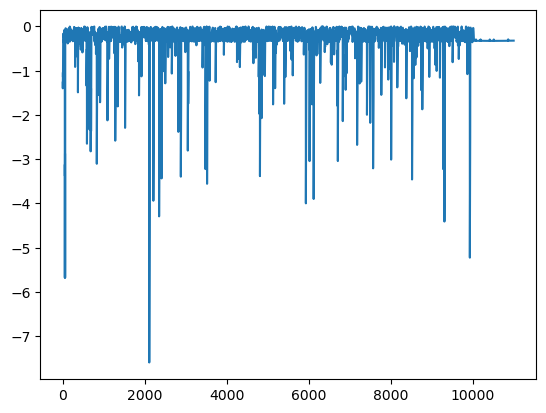

[(array([298.71475502,   2.99434197]), -0.00011236394012026696), (array([299.83611796,   2.93607176]), -0.00011508738840377287), (array([297.84630444,   2.95563547]), -0.00012187526679057208)]


In [65]:
# write a deep q learning agent that takes in the state space and outputs the action space
# the state space is power and scan speed
# action space is lower power, increase power, lower scan speed, increase scan speed
# the loss function = -(H_star(power, scan_speed)-115)**2 - 1000*((scan_speed - 3)**2)

# the agent should be able to learn the optimal power and scan speed to achieve the desired H_star

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math
import tqdm as tqdm
import random

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.0001, batch_size=32, model_name="model_0"):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.model_name = model_name
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self._build_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # self.criterion = torch.nn.MSELoss()
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        device = torch.device("cpu") # for now
        self.model.to(device)
        self.epochs = 100000

    def _build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state_tensor)).item()
            
            target_f = self.model(state_tensor)
            target_f[0][action] = target
            
            self.optimizer.zero_grad()
            self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, model_name="model_0.pth"):
        self.model.load_state_dict(torch.load(model_name))

    def save(self, model_name="model_0.pth"):
        torch.save(self.model.state_dict(), model_name)

    @staticmethod
    def H_star(power, scan_speed, absorptivity=0.3, rho=2500.0, Cp=915.0, T_solid=853.0, T_0=300.0, hf=40000.0, Diffusivity=0.000097, beam_diameter=0.0001):
        H = (4 * absorptivity * power)/(np.pi*rho*(Cp*(T_solid - T_0) + hf) * np.sqrt(Diffusivity * scan_speed * beam_diameter**3))
        return H
    
    @staticmethod
    def reward(power, scan_speed):
        H = DQNAgent.H_star(power, scan_speed)
        return (-((H * 0.3*0.9*100)-130)**2 - 1000*((scan_speed - 3)**2))/36000
    
    def train(self, episodes=1000):
        for e in range(episodes):
            state = np.random.rand(2)
            state[0] = state[0] * 350 + 50  # Scale power to 50-400 range
            state[1] = state[1] * 2.8 + 0.2  # Scale scan speed to 0.2-3 range
            for time in range(10):
                action = self.act(state)
                
                # Apply the action
                next_state = state.copy()
                if action == 0:  # lower power
                    next_state[0] = max(50, next_state[0] - 10)
                elif action == 1:  # increase power
                    next_state[0] = min(400, next_state[0] + 10)
                elif action == 2:  # lower scan speed
                    next_state[1] = max(0.2, next_state[1] - 0.1)
                elif action == 3:  # increase scan speed
                    next_state[1] = min(3, next_state[1] + 0.1)
                
                reward = self.reward(next_state[0], next_state[1])
                done = False
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.replay()
            print(f"episode: {e}/{episodes}, reward: {reward}")
        self.save()

    def test(self):
        self.load()
        state = np.random.rand(2)
        state[0] = state[0] * 350 + 50  # Scale power to 50-400 range
        state[1] = state[1] * 2.8 + 0.2  # Scale scan speed to 0.2-3 range
        for time in range(1000):
            action = self.act(state)
            next_state = state.copy()
            if action == 0:  # lower power
                next_state[0] = max(50, next_state[0] - 10)
            elif action == 1:  # increase power
                next_state[0] = min(400, next_state[0] + 10)
            elif action == 2:  # lower scan speed
                next_state[1] = max(0.2, next_state[1] - 0.1)
            elif action == 3:  # increase scan speed
                next_state[1] = min(3, next_state[1] + 0.1)
            reward = self.reward(next_state[0], next_state[1])
            done = False
            self.remember(state, action, reward, next_state, done)
            state = next_state
            self.replay()
            print(f"test_epoch: {time} / 1000 | reward: {reward}")

    def plot_rewards(self):
        rewards = []
        for state, action, reward, next_state, done in self.memory:
            rewards.append(reward)
        plt.plot(rewards)
        plt.show()

    def optimal_values(self):
        # print the 3 most optimal values of power and scan speed
        optimal_values = []
        for state, action, reward, next_state, done in self.memory:
            optimal_values.append((state, reward))
        optimal_values = sorted(optimal_values, key=lambda x: x[1], reverse=True)
        return optimal_values[:3]
    


power = np.linspace(50, 400, 100)
scan_speed = np.linspace(0.2, 3, 100)

name = "model_0"
agent = DQNAgent(2, 4, model_name=name)
agent.train()
agent.test()
agent.plot_rewards()
print(agent.optimal_values())


In [66]:
# power = np.linspace(50, 400, 100)
# scan_speed = np.linspace(0.2, 3, 100)

# agent = DQNAgent(2, 4)
# agent.train()
# agent.test()
# agent.plot_rewards()

